## CS536: Pruning Decision Trees
#### Done by - Vedant Choudhary, vc389
The purpose of this problem set is to look at the effect of pruning on decision trees. As before, we need a generative model for data so that we can run repeatable experiments. Let ${(X_1, Y_1),(X_2, Y_2), . . . ,(X_m, Y_m)}$ denote a data set, where $X_i$ represents a vector of k (binary) feature values, and $Y_i$ is a corresponding binary class or label that we will need to learn to be able to predict from the X-values.
We generate data via the following scheme, defining a distribution for our data set: Let $X = (X_0, X_1, X_2, X_3, . . . , X_{20})$
be a vector of binary values, satisfying the following
- $X_0 = 1$ with probability 1/2, $X_0 = 0$ with probability 1/2
- For i = 1, . . . , 14, $X_i = X_{i−1}$ with probability 3/4, and $X_i = 1 − X_{i−1}$ with probability 1/4.
- For i = 15, . . . , 20, $X_i = 1$ with probability 1/2, and $X_i = 0$ with probability 1/2.
The first feature value is uniformly random, and the next 14 features are strongly correlated, but the last 5 features are
independent of everything else. There are 21 X-variables, so there are $2^{21} ≈ 2 mil$ possible input X. Some of these are more likely than others. In general, we expect the training data to cover only a fraction of the total possible inputs, so consider data sets of size m where m ranges from 10 to 10,000. We then define Y to be

$$Y = majority(X_1, ....., X_7) if X_0 = 0$$
$$Y = majority(X_8, ....., X_14) if X_0 = 1$$

That is, if $X_0 = 0$, we take the majority value of $X_1$ through $X_7$ - otherwise we take the majority value of $X_8$ through
$X_{14}$. The values $X_{15}$ through $X_{20}$ are nothing but noise.

#### 1. Write a function to generate m samples of (X, Y), and another to fit a tree to that data using ID3. Write a third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data, err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data points as a function of m. Does this agree with your intuition?

In [24]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm
from collections import Counter

%matplotlib inline

In [35]:
# Creating X (feature) vectors for the data
def create_data(k, m):
    X = [[0]*k for i in range(m)]
    for i in range(m):
        X[i][0] = int(np.random.choice(2, size=1))
        for j in range(1, k):
            if j <=14:
                temp = np.random.choice(2, 1, p=[0.25,0.75])
                if temp == 1:
                    X[i][j] = X[i][j-1]
                else:
                    X[i][j] = 1 - X[i][j-1]
            else:
                temp = np.random.choice(2, 1, p=[0.5,0.5])
                if temp == 1:
                    X[i][j] = 1
                else:
                    X[i][j] = 0
    return X 

# Return most common value
def majority(l):
    occurence = Counter(l)
    return occurence.most_common(1)[0][0]

# Creating target column for the data
def create_y(X, k, m):
    y = []
    for i in range(m):
        if X[i][0] == 1:
            y.append(majority(X[i][1:8]))
        elif X[i][0] == 0:
            y.append(majority(X[i][8:15]))
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m):
    X = np.asarray(create_data(k, m))
    y = np.asarray(create_y(X, k, m)).reshape(m, 1)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(k)]+['Y'])
    return data

In [37]:
# Global variables, k - number of features, m - sample size, epsilon - a very small value (e-16) used to avoid divide by zero errors
k, m = 21, 100
epsilon = np.finfo(float).eps

train_data = create_dataset(k, m)
train_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,0,1,1,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,1
2,1,1,1,0,0,0,0,1,1,1,...,1,1,0,1,1,0,0,1,1,0
3,0,0,0,0,1,0,0,1,1,1,...,1,1,0,1,1,0,0,1,1,1
4,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,0,1,0,1,1,1


In [50]:
# Class for Decision Tree
class DecisionTree(): 
    '''
    Entropy function calculates the entropy of unique values in the target data i.e. entropy for 0 and 1
    Input - dataset
    Return - Entropy value for target
    '''
    def entropy(self, data):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
        entropy_y = 0
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
        
        for val in target_vals:
            p = data[target].value_counts()[val]/len(data[target])
            entropy_y += -p*np.log2(p)
        return entropy_y
    
    '''
    Calculates the conditional entropy of the target variable w.r.t to the features i.e. H(Y|X)
    Input - dataset, feature
    Return - Conditional entropy    
    '''
    def conditional_entropy(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        cond_entropy_y = 0
        
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            entropy = 0
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + epsilon)
                entropy += -(e)*np.log2(e + epsilon)
            cond_entropy_y += -(denom/len(data))*entropy
            
        return abs(cond_entropy_y)
    
    '''
    Calculates information gain value
    Input - dataset
    Return - max value of information gain feature
    '''
    def information_gain_split(self, data):
        IG = []
#         For every feature except the last column(y) in the dataset
        for key in data.keys()[:-1]:
            IG.append(self.entropy(data) - self.conditional_entropy(data, key))
        
        return data.keys()[:-1][np.argmax(IG)]
    
    '''
    Trims down the dataset as per the information gain node. Helps in building tree
    Input - dataset, node(which is the best split feature), val is either 0 or 1
    Return - trimmed dataset
    '''
    def get_subset(self, data, node, value):
        return data[data[node] == value].reset_index(drop=True)
    
    '''
    Builds the decision tree based on functions written above. It is a recursive function till leaf nodes found
    Input - dataset
    Return - the built decision tree, in a dictionary like format
    '''
    def build_tree(self, data, tree=None):
        target = data.keys()[-1]
        best_split = self.information_gain_split(data)
        feature_vals = data[best_split].unique()
        
        if tree is None:
            tree = {}
            tree[best_split] = {}
        
            
        for val in feature_vals:
            subset = self.get_subset(data, best_split, val)
            target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
#             print(target_val, target_counts)
            if len(target_counts) == 1:
                tree[best_split][val] = target_val[0]
            else:
                tree[best_split][val] = self.build_tree(subset)        

        return tree
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict(self, instance_data, tree):
        for node in tree.keys():
            value = instance_data[node]
            tree = tree[node][value]
            prediction = 0
            
            if type(tree) is dict:
                prediction = self.predict(instance_data, tree)
            else:
                prediction = tree
                break
        
        return prediction
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data, tree):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i], tree)
            if prediction != data.iloc[i][-1]:
                error += 1
        return error/len(data)    
    
    '''
    Generates multiple datasets and finds error on those datasets
    Input - Built decision tree, feature values, sample size of dataset
    Return - typical error
    '''
    def generate_data_and_typical_error(self, tree, k, m):
        typical_error = 0
        for i in range(10):
            data = create_dataset(k, m)
            typical_error += self.fit(data, tree)

        typical_error = typical_error/10
        return typical_error

In [51]:
dt = DecisionTree()
tree = dt.build_tree(train_data)
pprint.pprint(tree)

{'X7': {0: {'X3': {0: {'X13': {0: 0,
                               1: {'X0': {0: {'X14': {0: 0, 1: 1}}, 1: 0}}}},
                   1: {'X18': {0: {'X15': {0: 1,
                                           1: {'X11': {0: {'X0': {0: 0, 1: 1}},
                                                       1: 0}}}},
                               1: 0}}}},
        1: {'X1': {0: {'X13': {0: {'X3': {0: 0, 1: {'X4': {0: 0, 1: 1}}}},
                               1: {'X0': {0: {'X12': {0: {'X6': {0: 0, 1: 1}},
                                                      1: 1}},
                                          1: {'X2': {0: 0, 1: 1}}}}}},
                   1: {'X10': {0: {'X5': {0: {'X14': {0: 0, 1: 1}}, 1: 1}},
                               1: 1}}}}}}


In [52]:
error = dt.fit(train_data, tree)
error

0.0

In [59]:
def typical_error_with_m(k, tree):
    m = list(range(10, 1000, 10))
    typical_errors = []
    for sample_size in tqdm(range(len(m))):
        error = dt.generate_data_and_typical_error(tree, k, m[sample_size])
        typical_errors.append(error)
    
    plt.plot(m, typical_errors)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Typical error")
    plt.title("Typical error as a function of m")
    plt.show()

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


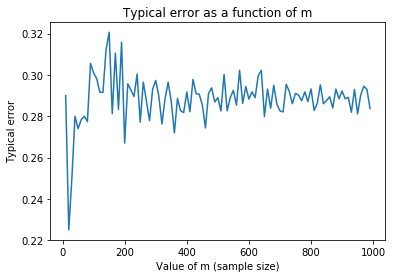

In [60]:
typical_error_with_m(k, tree)